# Analysis on secure logs

In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [3]:
import Reader
import ParamsExtractor2
import DataPreprocessor
import DeepLearningAnomalyDetection2

2024-07-01 07:52:31.381132: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 07:52:31.381693: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 07:52:31.384950: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 07:52:31.433954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 07:52:32.245493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Training

In [4]:
log_types = ['secure']
dates = ['20240418', '20240420', '20240429']
login_node_numbers = ['01', '02', '03', '10']

# Generate the list of file paths
file_paths = [f'/../../../temp_logs/{date}/login{num}.{logtype}.log' for date in dates for num in login_node_numbers for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    df_list.append(df)

['/../../../temp_logs/20240418/login01.secure.log', '/../../../temp_logs/20240418/login02.secure.log', '/../../../temp_logs/20240418/login03.secure.log', '/../../../temp_logs/20240418/login10.secure.log', '/../../../temp_logs/20240420/login01.secure.log', '/../../../temp_logs/20240420/login02.secure.log', '/../../../temp_logs/20240420/login03.secure.log', '/../../../temp_logs/20240420/login10.secure.log']


In [5]:
len(df_list)

8

In [6]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor2.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)
    df_list[i] = pd.concat([df_list[i], new_df], axis=1)

In [7]:
df_list[0].head()

,host,ident,pid,message,severity,facility,time,severity_numbers,facility_numbers,severity_scores,timedelta,ip,port,session,log key,log key spell
0,login01,systemd,37690,pam_unix(systemd-user:session): session opened...,info,authpriv,2024-04-18 00:00:01 +0200,6,10,1.0,0.0,-1,-1,opened,96,-1
1,login01,sshd,37759,Accepted publickey for root from 10.44.0.12 po...,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,1.0,10.44.0.12,44266,-1,97,52
2,login01,sshd,37759,pam_unix(sshd:session): session opened for use...,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,0.0,-1,-1,opened,96,-1
3,login01,sshd,37765,Received disconnect from 10.44.0.12 port 44266...,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,0.0,10.44.0.12,44266,-1,98,-1
4,login01,sshd,37765,Disconnected from user root 10.44.0.12 port 44266,info,authpriv,2024-04-18 00:00:02 +0200,6,10,1.0,0.0,10.44.0.12,44266,-1,99,55


In [8]:
for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    df_list[i] = enc

print(df_list[0].head())

   severity_scores  timedelta   port  log key  log key spell  col_0  col_1  \
0              1.0        0.0     -1       96             -1      0      0   
1              1.0        1.0  44266       97             52      1      0   
2              1.0        0.0     -1       96             -1      1      0   
3              1.0        0.0  44266       98             -1      1      0   
4              1.0        0.0  44266       99             55      1      0   

   col_2  col_3  col_4  ...  col_10  col_11  col_12  col_13  col_14  col_15  \
0      0      0      0  ...       0       0       3       0       0       0   
1      0      0      0  ...       0       1       1       0       0       0   
2      0      0      0  ...       0       1       2       0       0       0   
3      0      0      0  ...       0       0       1       0       0       0   
4      0      0      0  ...       0       0       1       0       0       0   

   col_16  col_17  col_18  col_19  
0       1       0   

In [9]:
for df in df_list:
    print(df.shape)

(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)
(1000, 25)


In [10]:
normal_dataset = df_list[0]

for i in range(1,len(df_list)):
    normal_dataset = np.vstack([normal_dataset, df_list[i]])

In [11]:
normal_dataset.shape

(8000, 25)

## Anomalies' dataset

In [12]:
log_types = ['secure']

# Generate the list of file paths
file_paths = [f'../data/linpeas_logs_1/{logtype}_logs.log' for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]

an_df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file_2(file_path)
    an_df_list.append(df)

In [13]:
an_df_list[0].head()

,host,ident,pid,message,severity,facility,time
0,localhost,sudo[3680]:,3680,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:39.520333-04:00
1,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:39.526046-04:00
2,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session closed for use...,info,authpriv,2024-06-22T11:55:39.974240-04:00
3,localhost,sudo[3693]:,3693,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:46.643379-04:00
4,localhost,sudo[3693]:,3693,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:46.655326-04:00


In [14]:
an_df_after = []

for i, df in enumerate(an_df_list):
    p = ParamsExtractor2.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    an_df_after.append(new_df)
    an_df_list[i] = pd.concat([an_df_list[i], new_df], axis=1)

In [15]:
an_df_list[0].head()

,host,ident,pid,message,severity,facility,time,severity_numbers,facility_numbers,severity_scores,timedelta,ip,port,session,log key,log key spell
0,localhost,sudo[3680]:,3680,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:39.520333-04:00,5,10,2.718282,0.000000,-1,-1,-1,414,-1
1,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:39.526046-04:00,6,10,1.000000,0.005713,-1,-1,opened,415,-1
2,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session closed for use...,info,authpriv,2024-06-22T11:55:39.974240-04:00,6,10,1.000000,0.448194,-1,-1,closed,100,53
3,localhost,sudo[3693]:,3693,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:46.643379-04:00,5,10,2.718282,6.669139,-1,-1,-1,416,56
4,localhost,sudo[3693]:,3693,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:46.655326-04:00,6,10,1.000000,0.011947,-1,-1,opened,415,-1


In [16]:
for i, df in enumerate(an_df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    an_df_list[i] = enc

print(an_df_list[0].head())

   severity_scores  timedelta port  log key  log key spell  col_0  col_1  \
0         2.718282   0.000000   -1      414             -1      1      1   
1         1.000000   0.005713   -1      415             -1      1      1   
2         1.000000   0.448194   -1      100             53      2      1   
3         2.718282   6.669139   -1      416             56      0      0   
4         1.000000   0.011947   -1      415             -1      0      0   

   col_2  col_3  col_4  ...  col_10  col_11  col_12  col_13  col_14  col_15  \
0      0      0      0  ...       0       0       2       0       0       0   
1      0      0      0  ...       0       0       2       0       0       0   
2      0      0      0  ...       0       0       1       0       0       0   
3      0      0      0  ...       0       0       2       0       0       2   
4      0      0      0  ...       0       0       2       0       0       2   

   col_16  col_17  col_18  col_19  
0       0       0       0       

In [17]:
# we test secure
# we take the lines from the 230th (detected pwd bruteforcing)
anomalous_dataset = an_df_list[0][230:]

In [18]:
anomalous_dataset.shape

(770, 25)

## Library implementation

In [19]:
normal_dataset_df = pd.DataFrame(normal_dataset, columns=anomalous_dataset.columns)

Mean normal reconstruction error: 0.0010372106185397697
Mean anomalous reconstruction error: 0.4544233477224328


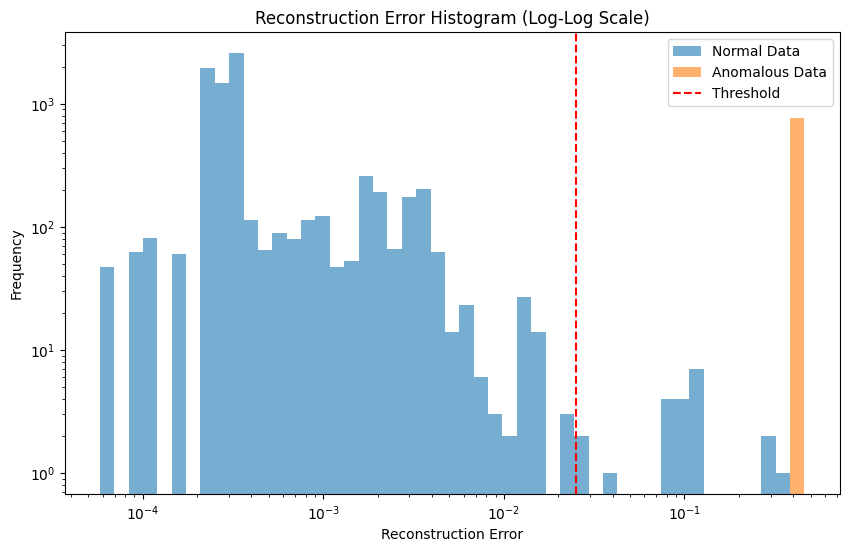

Threshold for anomaly detection: 0.025207635453900812
Number of anomalies detected: 770
Number of false positives detected: 20


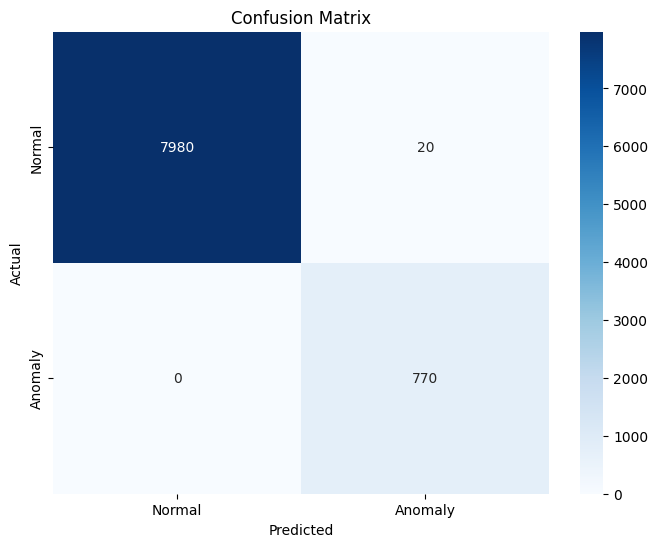

In [20]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset, 'autoencoder', plots=[0,0,1,1])

Mean normal reconstruction error: 0.007415197246810892
Mean anomalous reconstruction error: 0.5108133130215501


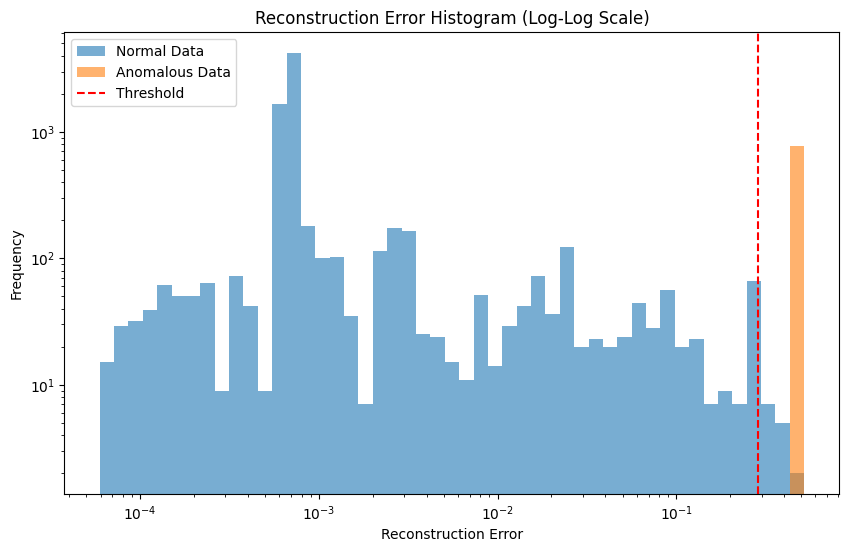

Threshold for anomaly detection: 0.28773591985656194
Number of anomalies detected: 770
Number of false positives detected: 20


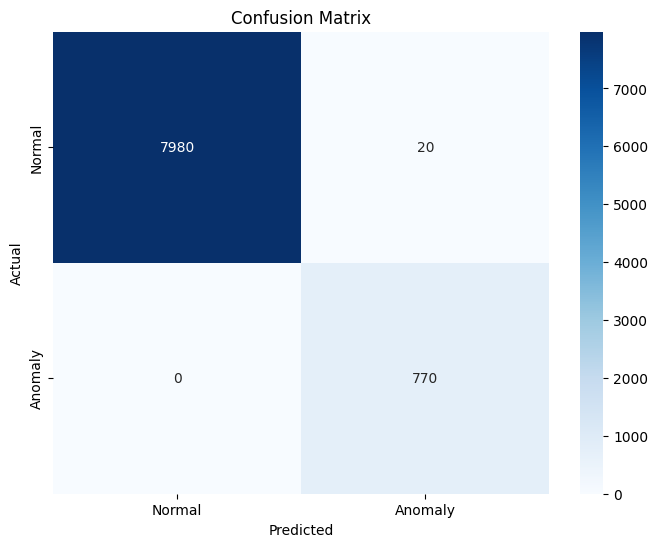

In [21]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies_vae, reconstructed_anomalies_vae = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset, 'vae', plots=[0,0,1,1])

## Ensemble method

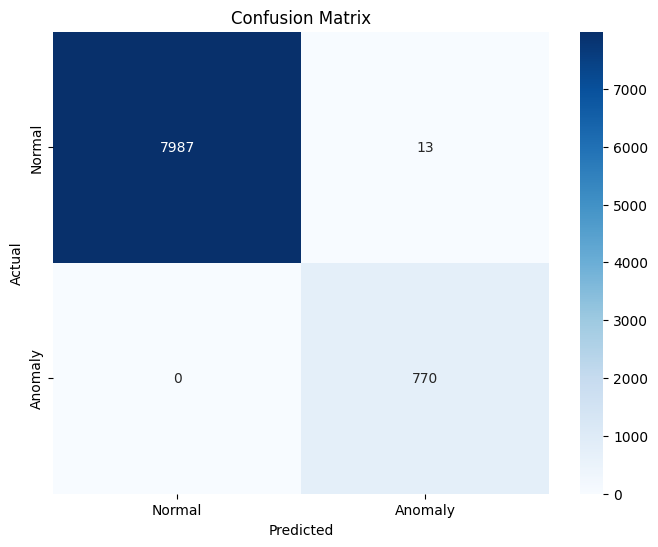

In [22]:
d_an_det.ensemble_method(normal_dataset_df, anomalous_dataset, plots=[1])

In [23]:
# Example predictions from two models (replace with your actual predictions)
predictions_model1 = reconstructed_anomalies
predictions_model2 = reconstructed_anomalies_vae

# Combine predictions using logical OR (voting scheme)
combined_predictions = np.logical_and(predictions_model1, predictions_model2).astype(int)

# Example thresholding (adjust as needed)
threshold = 0.5  # Simple majority voting

# Convert to final anomaly predictions based on threshold
final_predictions = (combined_predictions >= threshold).astype(int)

# Print or use the final predictions
print("Combined Predictions:", combined_predictions)
print("Final Anomaly Predictions:", final_predictions)

Combined Predictions: [0 0 0 ... 1 1 1]
Final Anomaly Predictions: [0 0 0 ... 1 1 1]


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

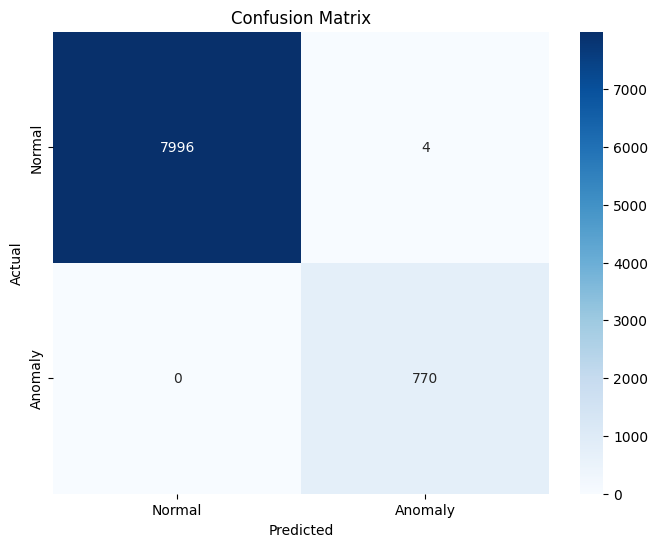

In [25]:
# Example ground truth and predictions (replace with your actual data)
ground_truth = true_anomalies
predictions = final_predictions
            
# Calculate confusion matrix
cm = confusion_matrix(ground_truth, predictions)
            
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Normal', 'Anomaly'], 
                        yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()